# Image caption with attention

# 2. Translating images to text using *Bahdenau Attention*

Ok so our previous model converged for 5 epochs but loss started to increase slightly when we trained it 20 epochs. Let's now use **Attention** to translate images to text, for 20 epochs, and compare.

The **Attention mechanism** is now forever associated with language modeling. Our code is based on [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/pdf/1502.03044.pdf) classic paper.

Instead of `VGG16`, we will preprocess and cache a subset of images using the `Inception V3` CNN stack, train an encoder-decoder model, and generate captions on new images using the trained model.

In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [2]:
# Download caption annotation files

annotation_folder = 'coco/annotations'


# Download image files

image_folder = 'coco/train2017'

PATH = image_folder

Let's read the json file and produce our annotations vector:

In [3]:
# Read the json file
annotation_file = 'coco/annotations/captions_train2017.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [4]:
len(annotations['annotations'])

591753

### Taking the complete training set

We will use our usual `<start>` and `<end>` sentinels.

First, since we're going to be doing a lot of processing, let's experiment with `tqdm`, which is a great tool because it gives us an ETA as well.

In [5]:
import time
import sys
from tqdm import trange

def do_something():
    time.sleep(1)

def do_another_something():
    time.sleep(0.5)

for i in trange(2, file=sys.stdout, desc='outer loop'):
    do_something()

    for j in trange(10,file=sys.stdout, leave=False, unit_scale=True, desc='inner loop'):
        do_another_something()

outer loop:   0%|                                         | 0/2 [00:00<?, ?it/s]
inner loop:   0%|                                   | 0.00/10.0 [00:00<?, ?it/s]
inner loop:  10%|██▊                         | 1.00/10.0 [00:00<00:04, 1.99it/s]
inner loop:  20%|█████▌                      | 2.00/10.0 [00:01<00:04, 1.97it/s]
inner loop:  30%|████████▍                   | 3.00/10.0 [00:01<00:03, 1.97it/s]
inner loop:  40%|███████████▏                | 4.00/10.0 [00:02<00:03, 1.97it/s]
inner loop:  50%|██████████████              | 5.00/10.0 [00:02<00:02, 1.97it/s]
inner loop:  60%|████████████████▊           | 6.00/10.0 [00:03<00:02, 1.97it/s]
inner loop:  70%|███████████████████▌        | 7.00/10.0 [00:03<00:01, 1.98it/s]
inner loop:  80%|██████████████████████▍     | 8.00/10.0 [00:04<00:01, 1.97it/s]
inner loop:  90%|█████████████████████████▏  | 9.00/10.0 [00:04<00:00, 1.97it/s]
inner loop: 100%|████████████████████████████| 10.0/10.0 [00:05<00:00, 1.97it/s]
outer loop:  50%|███████████

In [6]:
from tqdm import tqdm

def do_something():
    time.sleep(1)

with tqdm(total=100, file=sys.stdout) as pbar:
    for i in range(10):
        do_something()
        # Manually update the progress bar, useful for streams such as reading files.
        pbar.update(10)
        # Updates in increments of 10 stops at 100

100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.95it/s]


In [7]:
def do_something():
    time.sleep(1)

with tqdm(total=100, position=0) as pbar:
    for i in range(10):
        do_something()
        # Manually update the progress bar, useful for streams such as reading files.
        pbar.update(10)
        # Updates in increments of 10 stops at 100

100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.96it/s]


In [8]:
len(annotations['annotations'])

591753

In [9]:
annotations['annotations'][1000]

{'image_id': 69236,
 'id': 27851,
 'caption': 'Benches are next to a bush in a lighted park'}

What happens if we read the annotations serially?

In [17]:
PATH

'coco/train2017'

In [22]:
for i, annot in enumerate(annotations['annotations']):
    annot = annotations['annotations'][i]
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + '/' + '%012d.jpg' % (image_id)
    print(i, image_id, caption)
    if i > 500:
        break

0 203564 <start> A bicycle replica with a clock as the front wheel. <end>
1 322141 <start> A room with blue walls and a white sink and door. <end>
2 16977 <start> A car that seems to be parked illegally behind a legally parked car <end>
3 106140 <start> A large passenger airplane flying through the air. <end>
4 106140 <start> There is a GOL plane taking off in a partly cloudy sky. <end>
5 322141 <start> Blue and white color scheme in a small bathroom. <end>
6 322141 <start> This is a blue and white bathroom with a wall sink and a lifesaver on the wall. <end>
7 322141 <start> A blue boat themed bathroom with a life preserver on the wall <end>
8 203564 <start> The bike has a clock as a tire. <end>
9 16977 <start> two cars parked on the sidewalk on the street <end>
10 106140 <start> An airplane that is, either, landing or just taking off. <end>
11 322141 <start> A bathroom with walls that are painted baby blue. <end>
12 571635 <start> A bathroom with a toilet, sink, and shower. <end>
13 3

You can see that annotations are referenced randomly with respect to their image file. Since we want to take complete dataset, it makes sense to arrange the images by their numeric title.

So we do it this way:

In [25]:
from tqdm import tqdm

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

with tqdm(total=len(annotations['annotations']), position=0) as pbar:
    for i, annot in enumerate(annotations['annotations']):
        caption = '<start> ' + annot['caption'] + ' <end>'
        image_id = annot['image_id']
        
        full_coco_image_path = PATH + '/' + '%012d.jpg' % (image_id)
        
        pbar.update(1)

        all_img_name_vector.append(full_coco_image_path)
        all_captions.append(caption)
        
# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

100%|██████████████████████████████| 591753/591753 [00:00<00:00, 2165191.92it/s]


In [26]:
len(train_captions), len(all_captions)

(591753, 591753)

If you want to read in *all* images and captions, and *then* limit the dataset, you could do it this way:

### Don't run the following cell, it is here just as an alternative option!

# Preprocessing the images using InceptionV3
Let's use InceptionV3 (which is pretrained on [Imagenet](http://www.image-net.org/)) to classify each image. We'll extract features from the last convolutional layer.

So we need to convert the images into InceptionV3's expected format by resizing the images to 299 pixels by 299 pixels.

In [27]:
def load_image(image_path):
    #print('load_image: ', image_path)
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

Let's create a `tf.keras` model where the output layer is the last convolutional layer in the InceptionV3 architecture. 

The shape of the output of this layer is 8x8x2048. We will use the last convolutional layer, and won't perform  initialization during training because it can become a bottleneck.

We will forward each image through the Inception network and store the resulting vector in a dictionary (image_name --> feature_vector). After all the images are passed through the network, we'll pickle the dictionary and save it to disk.

If you run the cell below for the first time, it will take some time to download the Inception network weights.

In [28]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [29]:
image_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, None, None, 32)       96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, None, None, 32)       0         ['batch_normalizati

                                                                                                  
 conv2d_105 (Conv2D)         (None, None, None, 32)       6144      ['average_pooling2d_9[0][0]'] 
                                                                                                  
 batch_normalization_99 (Ba  (None, None, None, 64)       192       ['conv2d_99[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_101 (B  (None, None, None, 64)       192       ['conv2d_101[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_104 (B  (None, None, None, 96)       288       ['conv2d_104[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_111 (Activation  (None, None, None, 96)       0         ['batch_normalization_111[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_112 (Activation  (None, None, None, 64)       0         ['batch_normalization_112[0][0
 )                                                                  ]']                           
                                                                                                  
 mixed1 (Concatenate)        (None, None, None, 288)      0         ['activation_106[0][0]',      
                                                                     'activation_108[0][0]',      
          

 )                                                                  ]']                           
                                                                                                  
 conv2d_122 (Conv2D)         (None, None, None, 96)       55296     ['activation_121[0][0]']      
                                                                                                  
 batch_normalization_122 (B  (None, None, None, 96)       288       ['conv2d_122[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_122 (Activation  (None, None, None, 96)       0         ['batch_normalization_122[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_12

                                                                                                  
 conv2d_124 (Conv2D)         (None, None, None, 192)      147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_127 (Conv2D)         (None, None, None, 192)      172032    ['activation_126[0][0]']      
                                                                                                  
 conv2d_132 (Conv2D)         (None, None, None, 192)      172032    ['activation_131[0][0]']      
                                                                                                  
 conv2d_133 (Conv2D)         (None, None, None, 192)      147456    ['average_pooling2d_12[0][0]']
                                                                                                  
 batch_normalization_124 (B  (None, None, None, 192)      576       ['conv2d_124[0][0]']          
 atchNorma

 activation_141 (Activation  (None, None, None, 160)      0         ['batch_normalization_141[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_13 (Aver  (None, None, None, 768)      0         ['mixed4[0][0]']              
 agePooling2D)                                                                                    
                                                                                                  
 conv2d_134 (Conv2D)         (None, None, None, 192)      147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_137 (Conv2D)         (None, None, None, 192)      215040    ['activation_136[0][0]']      
                                                                                                  
 conv2d_14

 atchNormalization)                                                                               
                                                                                                  
 activation_146 (Activation  (None, None, None, 160)      0         ['batch_normalization_146[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_151 (Activation  (None, None, None, 160)      0         ['batch_normalization_151[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_14 (Aver  (None, None, None, 768)      0         ['mixed5[0][0]']              
 agePooling2D)                                                                                    
          

                                                                                                  
 batch_normalization_156 (B  (None, None, None, 192)      576       ['conv2d_156[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_161 (B  (None, None, None, 192)      576       ['conv2d_161[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_156 (Activation  (None, None, None, 192)      0         ['batch_normalization_156[0][0
 )                                                                  ]']                           
                                                                                                  
 activatio

 )                                                                  ]']                           
                                                                                                  
 conv2d_165 (Conv2D)         (None, None, None, 320)      552960    ['activation_164[0][0]']      
                                                                                                  
 conv2d_169 (Conv2D)         (None, None, None, 192)      331776    ['activation_168[0][0]']      
                                                                                                  
 batch_normalization_165 (B  (None, None, None, 320)      960       ['conv2d_165[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_169 (B  (None, None, None, 192)      576       ['conv2d_169[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_176 (Activation  (None, None, None, 384)      0         ['batch_normalization_176[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_177 (Activation  (None, None, None, 384)      0         ['batch_normalization_177[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_normalization_178 (B  (None, None, None, 192)      576       ['conv2d_178[0][0]']          
 atchNormalization)                                                                               
          

 )                                                                  ]']                           
                                                                                                  
 activation_182 (Activation  (None, None, None, 384)      0         ['batch_normalization_182[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_185 (Activation  (None, None, None, 384)      0         ['batch_normalization_185[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_186 (Activation  (None, None, None, 384)      0         ['batch_normalization_186[0][0
 )                                                                  ]']                           
          

## Caching the features extracted from InceptionV3
Let's pre-process each image with InceptionV3 and cache the output to disk. 



In [30]:
len(img_name_vector)

591753

Let's run all our images through Inception to generate each image's **thought vector**, and store each in an `.npy` file.

We are going to read images into Inception in batches. I use batch number, 16. But you could change that to 32 for example.

In [31]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions
First, we tokenize the captions by splitting on spaces. 

This gives us a vocabulary of all of the unique words in the target language (`surfing`, `football`, etc.).

Next, we limit the vocabulary size to the top 5,000 words (to save memory). We replace all other words with the token "UNK" (unknown).

We then create word-to-index and index-to-word mappings, and pad all sequences to be the same length as the longest one.

In [32]:
len(train_captions), len(img_name_vector)

(591753, 591753)

In [33]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [34]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [35]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [36]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [37]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [38]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
max_length

52

## Splitting the data into training and testing

In [39]:
len(img_name_vector)

591753

In [40]:
len(cap_vector)

591753

In [41]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [42]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(473402, 473402, 118351, 118351)

## Creating a `tf.data` dataset for training
Let's create a `tf.data` dataset to use for training our model.

In [43]:
# You can change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [44]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [45]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Bahdenau Attention Model

We will use a Bahdanau Attention model (a.k.a. *additive Attention*) decoder. The model architecture is from [here]((https://arxiv.org/pdf/1502.03044.pdf)).

Let's extract features from the lower convolutional layer of InceptionV3, giving us a vector of shape (8, 8, 2048).

Then squash that to a shape of (64, 2048).

This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).

We will use a GRU RNN to attend over the image and predict the next word.

In [46]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [47]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [48]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

Let's instantiate our encoder and decoder:

In [49]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

Optimizer and loss function:

In [50]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

Let's checkpoint. Make sure to create the `inception` folder.

In [51]:
#checkpoint_path = "data/training_checkpoints/inception"
checkpoint_path = 'coco/newcheck/inception'
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [52]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

Let's write our training step.

We extract the features stored in the respective .npy files and then pass those features through the encoder.

The encoder output, hidden state (initialized to 0) and the decoder input (which is the start token) is passed to the decoder.

The decoder returns the predictions and the decoder hidden state.

The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.

We use **teacher forcing** to decide the next input to the decoder (the technique where the target word is passed as the next input to the decoder).

The final step is to calculate the gradients and apply it to the optimizer and backpropagate!

We add the next cell in a separate cell because if we rerun the training cell in order to keep on training, 
the loss_plot array will be reset!

In [53]:
loss_plot = []

In [54]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

Now we're ready for our training loop.

In [56]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.6057
Epoch 1 Batch 100 Loss 0.6273
Epoch 1 Batch 200 Loss 0.6515
Epoch 1 Batch 300 Loss 0.6304
Epoch 1 Batch 400 Loss 0.6307
Epoch 1 Batch 500 Loss 0.5811
Epoch 1 Batch 600 Loss 0.5670
Epoch 1 Batch 700 Loss 0.6002
Epoch 1 Batch 800 Loss 0.6371
Epoch 1 Batch 900 Loss 0.5912
Epoch 1 Batch 1000 Loss 0.5647
Epoch 1 Batch 1100 Loss 0.5861
Epoch 1 Batch 1200 Loss 0.5818
Epoch 1 Batch 1300 Loss 0.5872
Epoch 1 Batch 1400 Loss 0.6317
Epoch 1 Batch 1500 Loss 0.6348
Epoch 1 Batch 1600 Loss 0.5562
Epoch 1 Batch 1700 Loss 0.5930
Epoch 1 Batch 1800 Loss 0.5565
Epoch 1 Batch 1900 Loss 0.5766
Epoch 1 Batch 2000 Loss 0.6803
Epoch 1 Batch 2100 Loss 0.5730
Epoch 1 Batch 2200 Loss 0.6657
Epoch 1 Batch 2300 Loss 0.6051
Epoch 1 Batch 2400 Loss 0.5539
Epoch 1 Batch 2500 Loss 0.5989
Epoch 1 Batch 2600 Loss 0.5858
Epoch 1 Batch 2700 Loss 0.6043
Epoch 1 Batch 2800 Loss 0.5977
Epoch 1 Batch 2900 Loss 0.6063
Epoch 1 Batch 3000 Loss 0.5976
Epoch 1 Batch 3100 Loss 0.6275
Epoch 1 Batch 3200 L

Epoch 4 Batch 3800 Loss 0.5024
Epoch 4 Batch 3900 Loss 0.5131
Epoch 4 Batch 4000 Loss 0.5075
Epoch 4 Batch 4100 Loss 0.5127
Epoch 4 Batch 4200 Loss 0.5016
Epoch 4 Batch 4300 Loss 0.5175
Epoch 4 Batch 4400 Loss 0.4687
Epoch 4 Batch 4500 Loss 0.5458
Epoch 4 Batch 4600 Loss 0.5684
Epoch 4 Batch 4700 Loss 0.5793
Epoch 4 Batch 4800 Loss 0.5502
Epoch 4 Batch 4900 Loss 0.4514
Epoch 4 Batch 5000 Loss 0.5149
Epoch 4 Batch 5100 Loss 0.5530
Epoch 4 Batch 5200 Loss 0.5069
Epoch 4 Batch 5300 Loss 0.5143
Epoch 4 Batch 5400 Loss 0.5001
Epoch 4 Batch 5500 Loss 0.5592
Epoch 4 Batch 5600 Loss 0.5075
Epoch 4 Batch 5700 Loss 0.5651
Epoch 4 Batch 5800 Loss 0.4976
Epoch 4 Batch 5900 Loss 0.5423
Epoch 4 Batch 6000 Loss 0.5697
Epoch 4 Batch 6100 Loss 0.5665
Epoch 4 Batch 6200 Loss 0.4819
Epoch 4 Batch 6300 Loss 0.4818
Epoch 4 Batch 6400 Loss 0.6113
Epoch 4 Batch 6500 Loss 0.5837
Epoch 4 Batch 6600 Loss 0.5492
Epoch 4 Batch 6700 Loss 0.5393
Epoch 4 Batch 6800 Loss 0.5076
Epoch 4 Batch 6900 Loss 0.5762
Epoch 4 

Let's plot our training loss throughout our training:

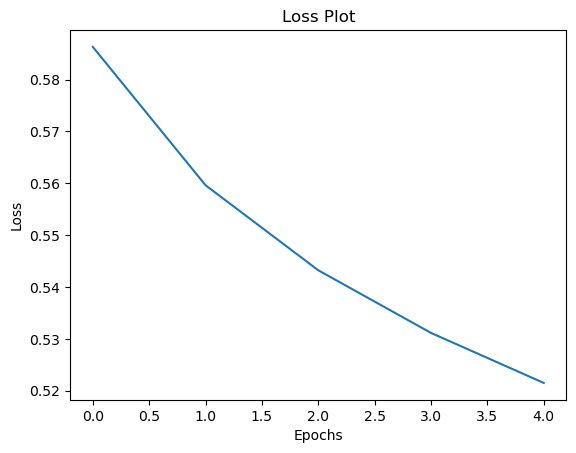

In [57]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Inference

So now we're ready for inference, that is, to translate images to text!

The evaluate function is similar to the training loop, except we don't use teacher forcing. 

The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.

We stop predicting when the model predicts the end sentinel `<end>`.

We store attention weights at every time step.

In [58]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [59]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Let's select an image at random from our evaluation dataset, translate it, and compare translation with the original caption:

Real Caption: <start> a stone building with many arched windows and a large clock <end>
Prediction Caption: a clock on this public library is in front of a building <end>


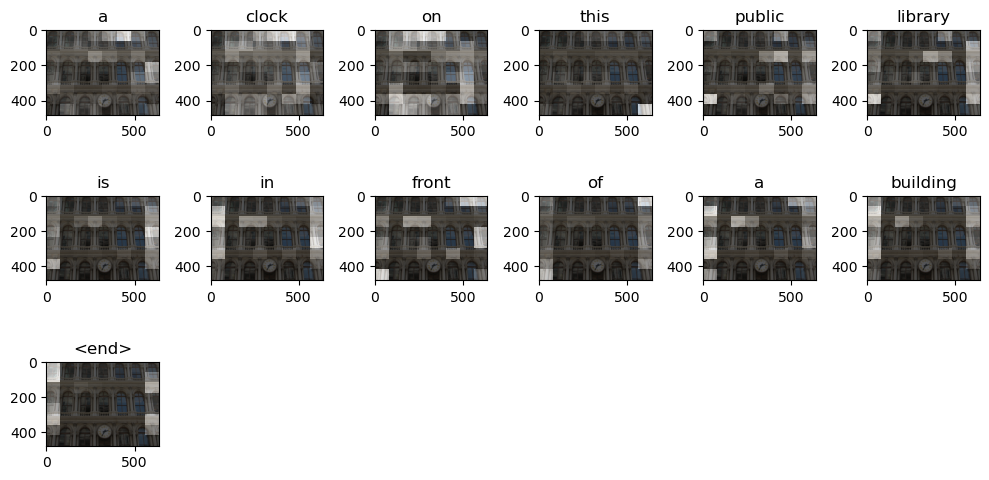

coco/train2017/000000272626.jpg


In [60]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
print(image)

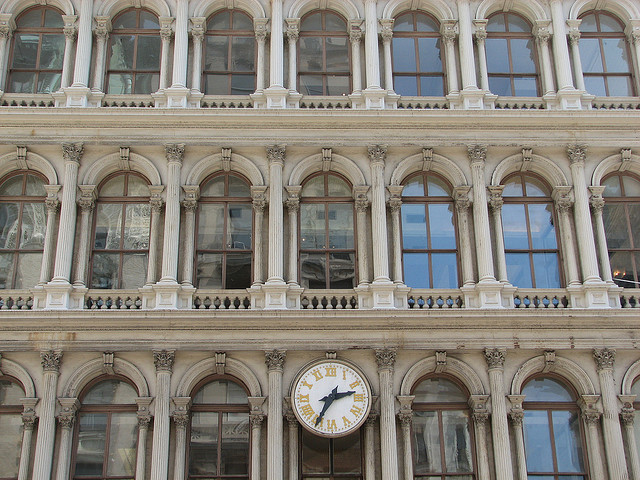

In [61]:
Image.open(image)

Let's find a picture on the Web of two dogs playing on the beach, and translate it:

24662/24662 [==============================] - 0s 0us/step
Prediction caption: three dogs riding horses on a beach behind a dog on a beach <end>


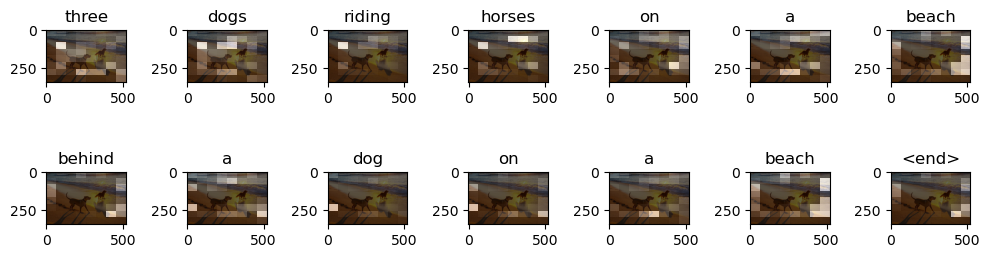

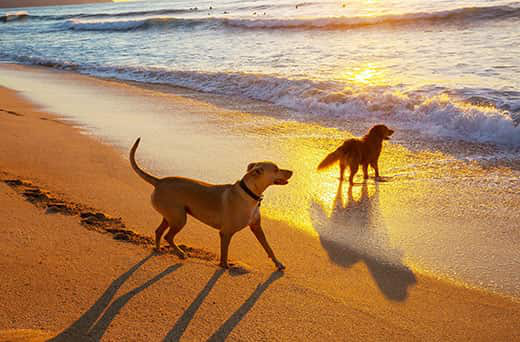

In [62]:
image_url = 'https://www.hillspet.com/content/dam/cp-sites/hills/hills-pet/en_us/exported/dog-care/Skyword/images/two-dogs-on-beach-at-sunset-SW.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)
        
result, attention_plot = evaluate(image_path)
print ('Prediction caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)

# opening the image and compare translation with the image itself
Image.open(image_path)

Let's select an image at random from our `flickr8k` dataset (one that did not work so well with our VGG16 model), and translate it with attention!

Prediction caption: a snowboarder walks a snow covered slope <end>
Original captions:
A snowboarder sits on a slope with skiers and boarders nearby
A snowboarder takes a rest on the mountainside
Snowboarders sitting in the snow while skiers take the hill
The snowboarder is sitting down
Two skiers stand , two sit on slopes


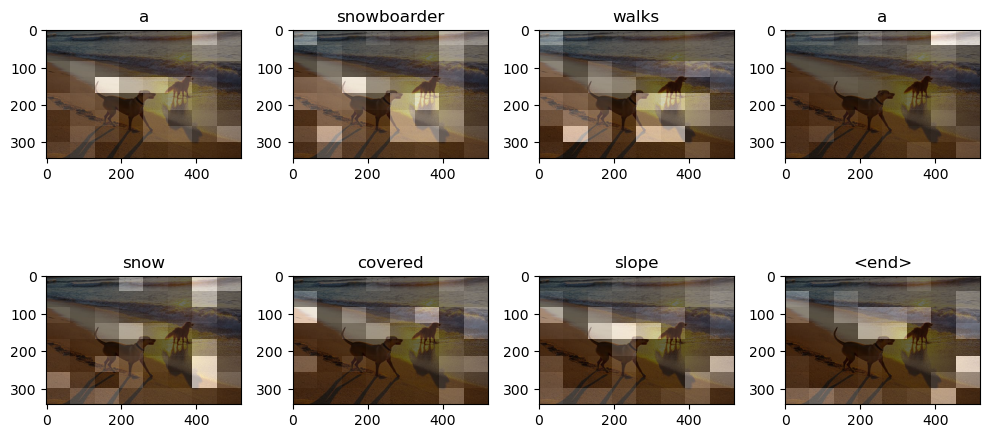

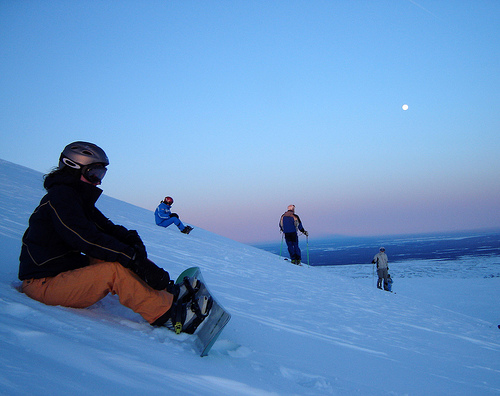

In [63]:
dogs_filename = 'flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/113678030_87a6a6e42e.jpg'
#dogs_caption = image_caption[100][1]
        
result, attention_plot = evaluate(dogs_filename)
print ('Prediction caption:', ' '.join(result))
#print ('Original caption:', ' '.join(dogs_caption))
# Manually, by opening the captions file /Users/dino/Documents/info7610/flickr8k/Flickr8k_text/Flickr8k.token.txt:
print("Original captions:")
print("A snowboarder sits on a slope with skiers and boarders nearby")
print("A snowboarder takes a rest on the mountainside")
print("Snowboarders sitting in the snow while skiers take the hill")
print("The snowboarder is sitting down")
print("Two skiers stand , two sit on slopes")
plot_attention(image_path, result, attention_plot)

# opening the image and compare translation with the image itself
Image.open(dogs_filename)

Let's compare with the same images used in the part 1 of assignment 8 (i.e. the vacation pictures). In the first part I did it one by one. Here I dynamically fetch all the images in the test folder.

Prediction caption: a statue of a man in a tiny statue by someone sitting on a ledge eating from a window sill <end>


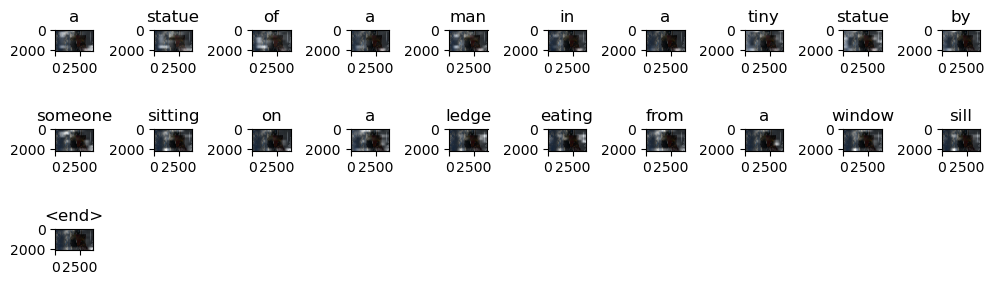

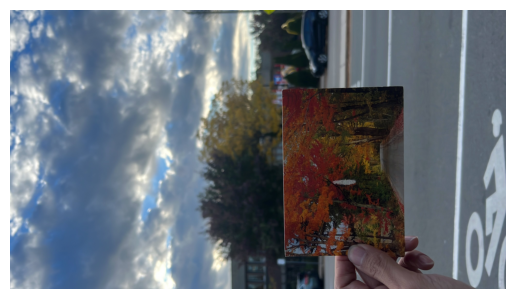

Prediction caption: various boats are spray in the air on a parking meter in a stop sign <end>


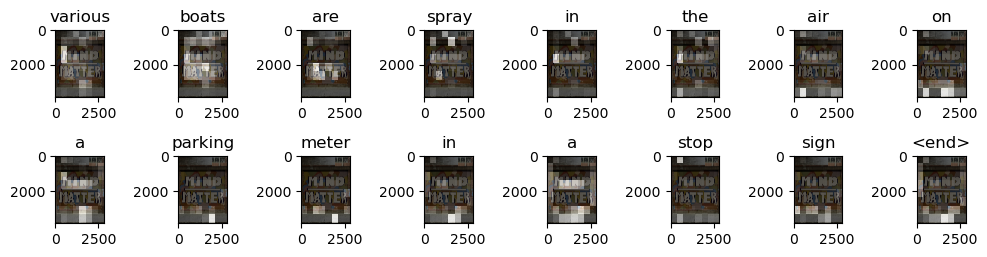

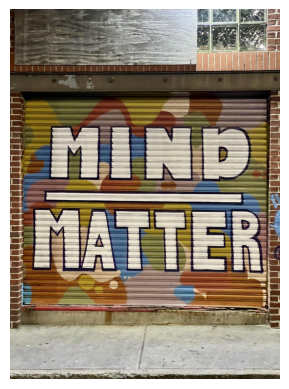

Prediction caption: a red bus sits parked next to a building <end>


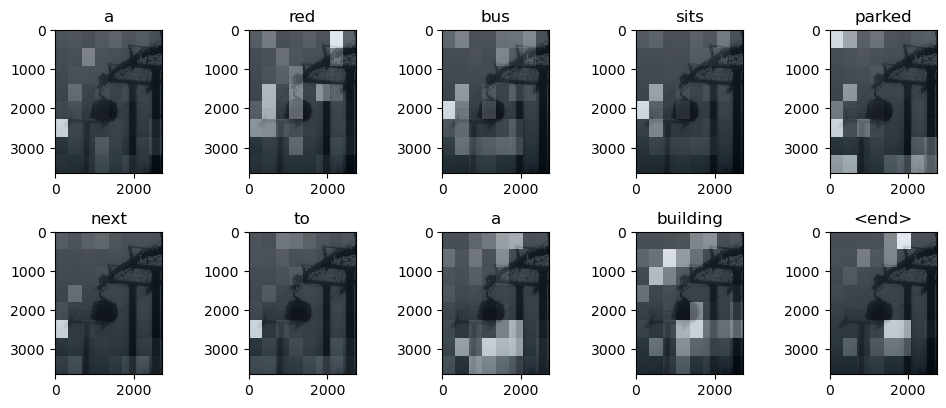

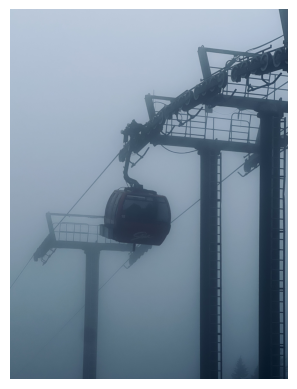

Prediction caption: a large colorful boat and a traffic signal seen in a city <end>


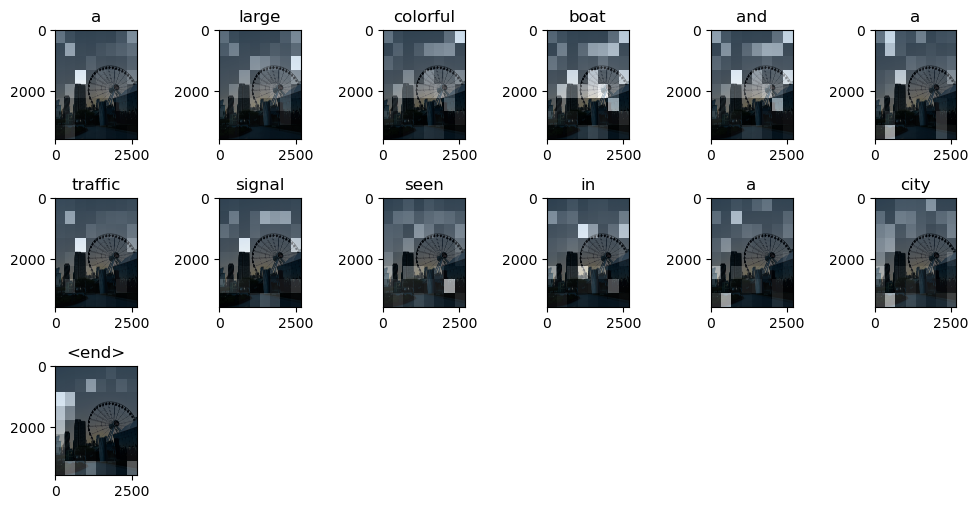

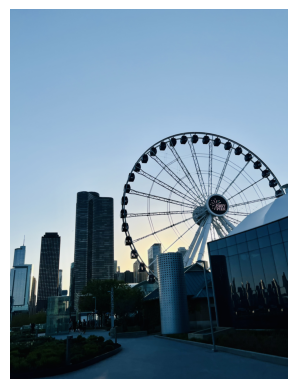

Prediction caption: a very tall brick covered in a red brick <unk> and stockings <end>


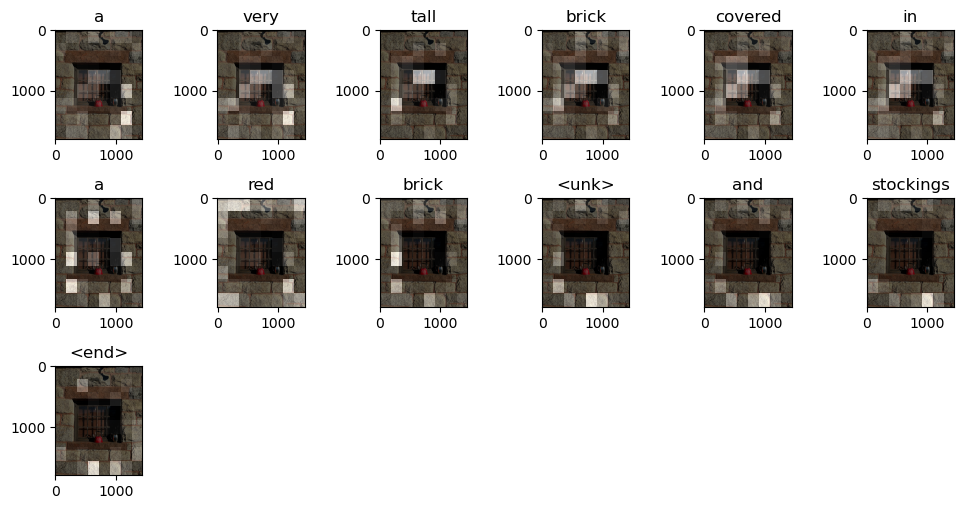

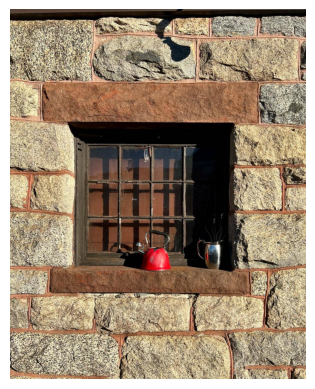

Prediction caption: a big city field with a body of water <end>


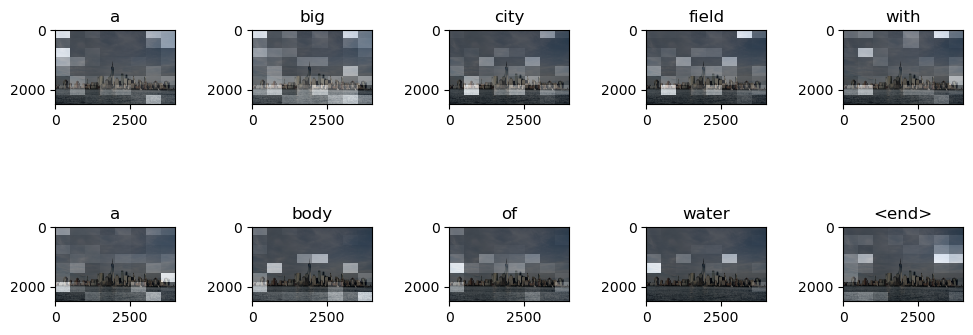

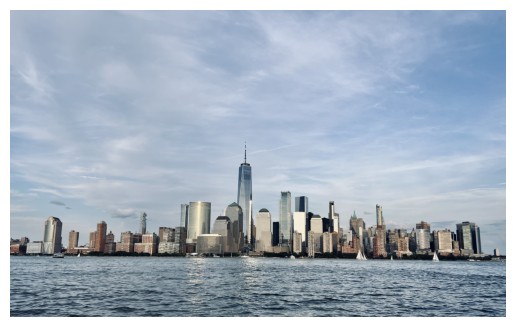

Prediction caption: three male in black <unk> a very high rise angle <end>


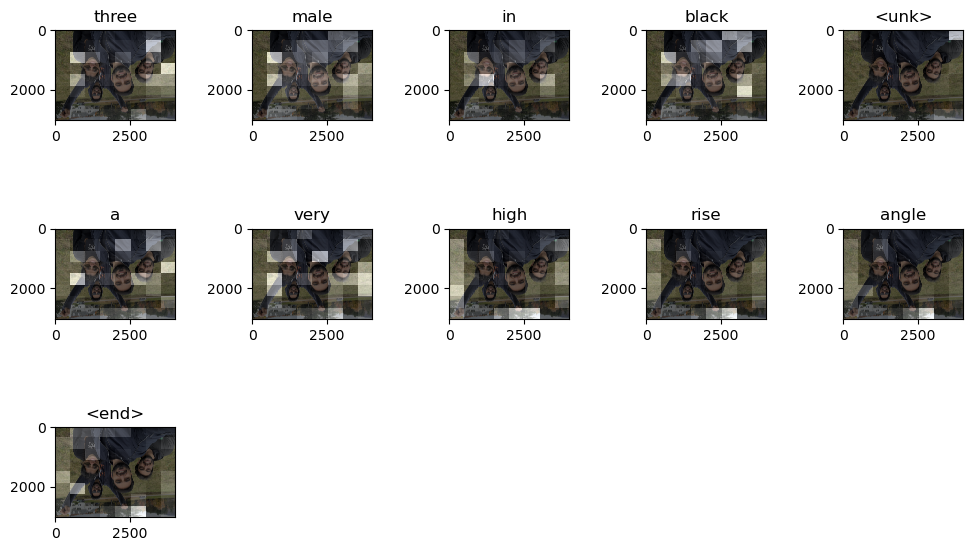

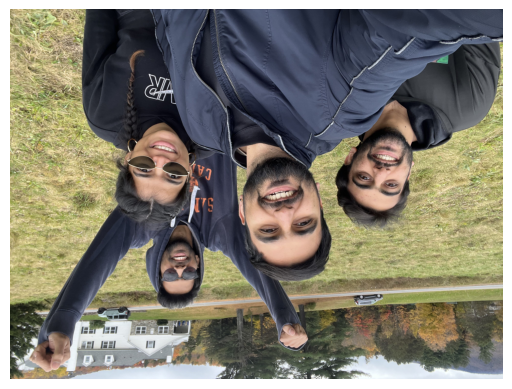

Prediction caption: a commuter train traveling down tracks it is making a turn at the station <end>


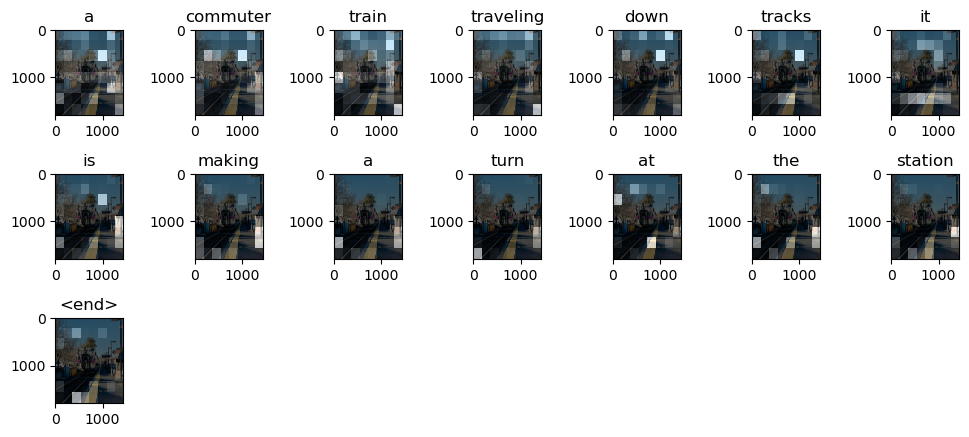

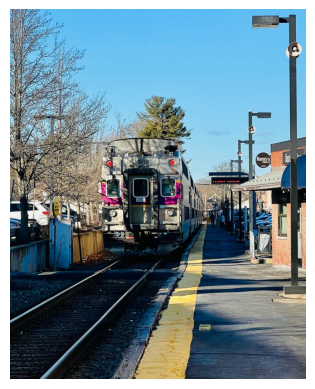

Prediction caption: a bright orange and white behind a broken cell phone peel the grass next to a road with grass <end>


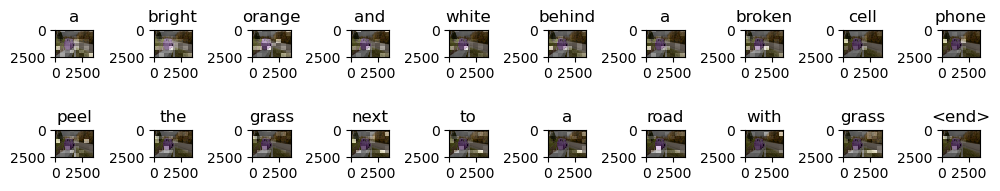

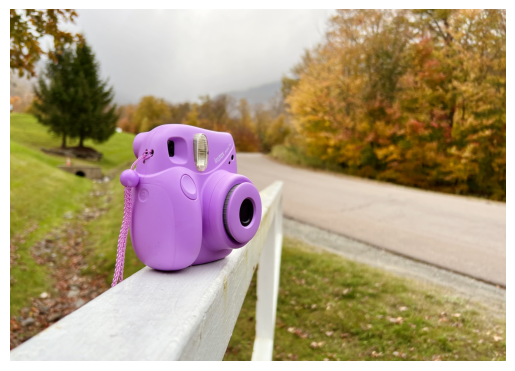

Prediction caption: a person that is sitting alone in the foreground <end>


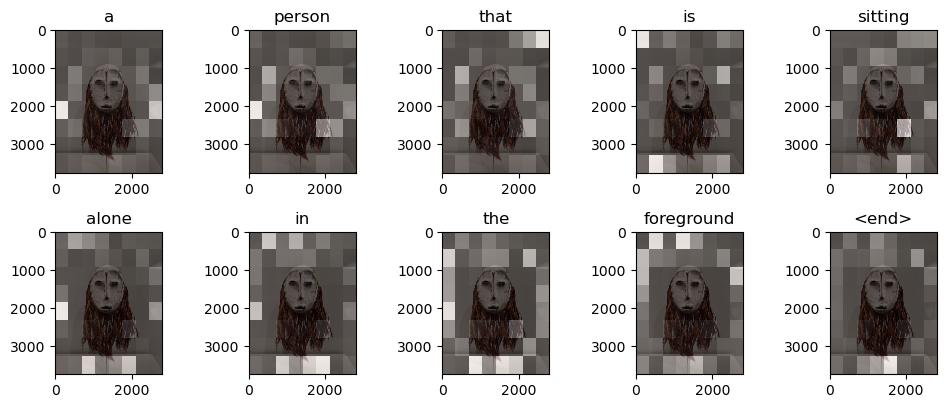

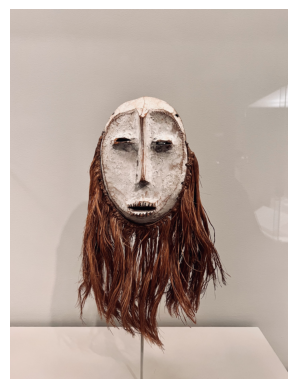

In [65]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Specify the directory containing your images
image_directory = 'coco/test'

# Get a list of all image file names in the directory
image_filenames = [filename for filename in os.listdir(image_directory) if filename.endswith('.jpg')]

# Iterate through each image file
for image_filename in image_filenames:
    # Construct the full path to the image file
    test_filename = os.path.join(image_directory, image_filename)

    # Process the image and generate captions
    result, attention_plot = evaluate(test_filename)
    print('Prediction caption:', ' '.join(result))

    # Plot the attention and show the image
    plot_attention(test_filename, result, attention_plot)

    # Open and display the image
    img = Image.open(test_filename)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
